In [23]:
from discopy import Ty, Word, Tensor
from discopy.grammar import brute_force
from random import random, uniform, seed
import os
import warnings
import numpy as np

In [24]:
warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
BATCH_SIZE = 30
EPOCHS = 40
SEED = 2

In [25]:
def read_data(filename):
    sentences = []
    with open(filename) as f:
        for line in f:
     
            sentences.append(line[0:].strip())
    return sentences


sentences = read_data('data/food_code.txt')

In [26]:
#Input data MC1
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            #sentences are split by , in our data set
            end_sentence = line.split(",")
            t = int(end_sentence[2])
            labels.append([t, 1-t])
            #there are two sentences per associated label
            #we need to make sure they are both used
            sentences.append(end_sentence[0])
            sentences.append(end_sentence[1])
    return labels, sentences

In [27]:
#we will use 15% of the data as a training set
labels, data = read_data('data/food_code.txt')
train_label, train_data = labels[15:100] , data[15:100]
test_label, test_data = labels[0:15] , data[0:15]

tag = []

#associate train_circuit to tags
food_keywords = ['chef','dish','meal','tasty','prepares']
code_keywords = ['programmer','code','hacker','writes']

positive_keywords = ['skilful','devoted','tasty','creates']

def label_data(all_data):
    tag = []

    for i in range(np.size(all_data)):
        words = [word for word in all_data[i].split()]
        for l in words:
            for j in food_keywords:
                #if l == j:
                    a = 0

            for k in code_keywords:
                #if l == k:
                    a = 1
            
            for h in positive_keywords:
                if l == h :
                    b = 1
                else:
                    b = 0
        
        tag.append([a,b])
    return tag


#rewrite training labels
train_labels = label_data(train_data)
test_labels = label_data(test_data)

In [28]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')
##for the training dataset
train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
##for the testing dataset
test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


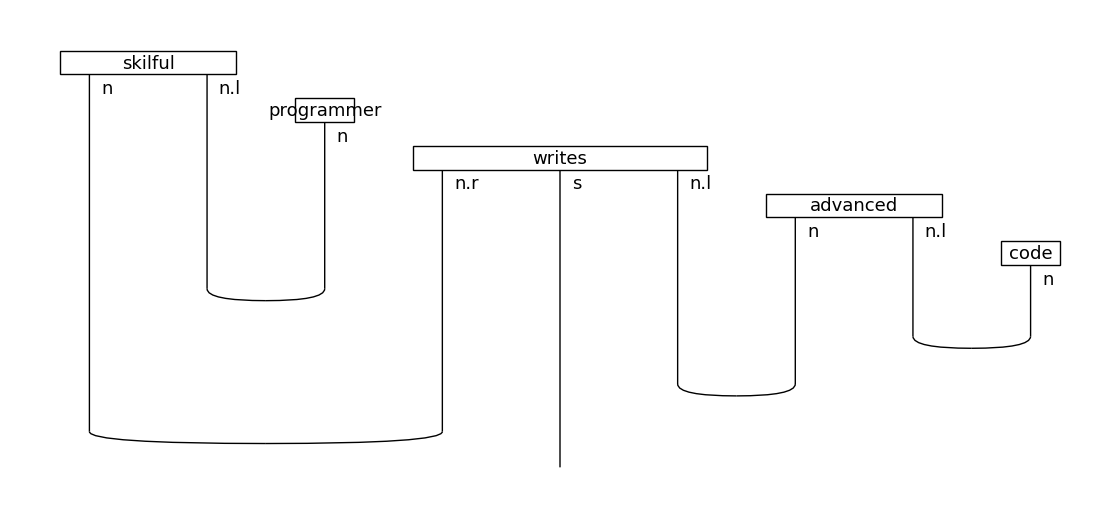

In [29]:
train_diagrams[0].draw(figsize=(11,5), fontsize=13)

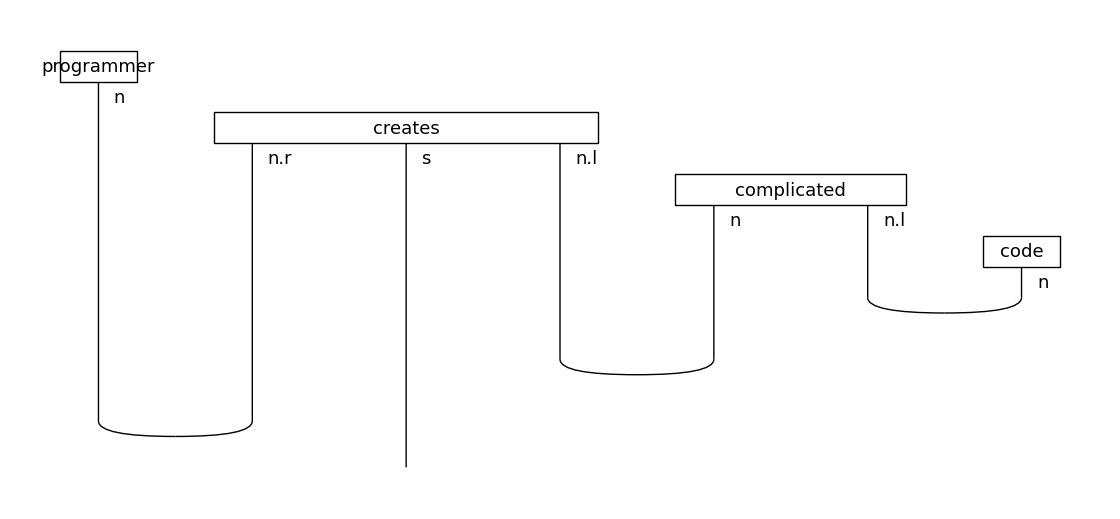

In [30]:
from lambeq import Rewriter

## Apply rewrite rules for sentences of both  training and testing dataset

#for the training features
rewriter = Rewriter(['prepositional_phrase', 'determiner','auxiliary','connector','coordination',
                     'object_rel_pronoun' , 'subject_rel_pronoun','postadverb' , 'preadverb','prepositional_phrase'])
r_train_diagrams = []

for diagram in train_diagrams:

  if diagram is not None:
      r_train_diagrams.append(rewriter(diagram))


        
r_train_diagrams[2].draw(figsize=(11,5), fontsize=13)

In [31]:
##for the testing features
r_test_diagrams = []

for diagram in test_diagrams:

  if diagram is not None:
      r_test_diagrams.append(rewriter(diagram))

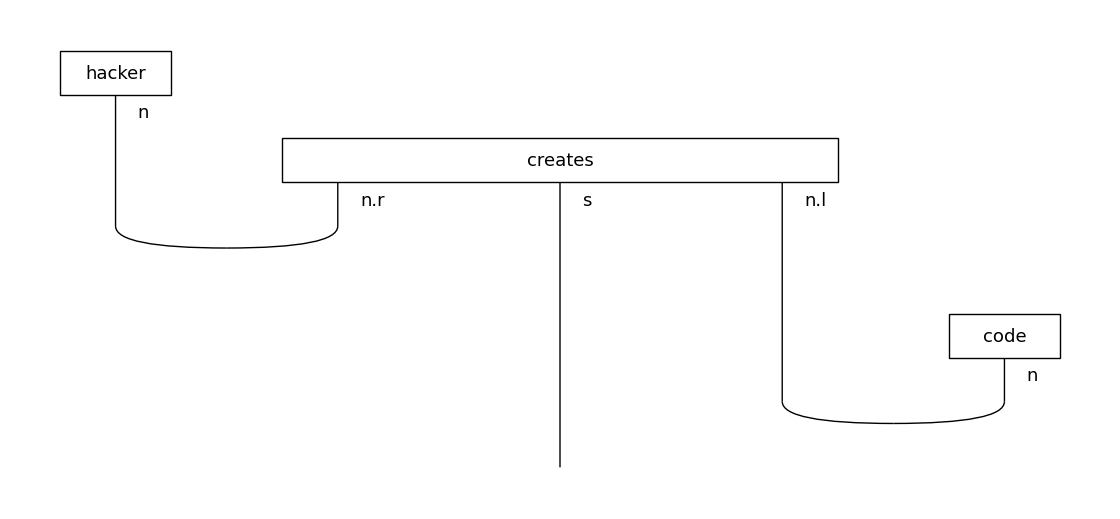

In [32]:
#normalizing the features

#from discopy.rigid import Diagram
n_train_diagrams = []
  
for diagram in r_train_diagrams:
     if diagram is not None:
       n_train_diagrams.append(diagram.normal_form())

n_test_diagrams = []

for diagram in r_test_diagrams:
     if diagram is not None:
       n_test_diagrams.append(diagram.normal_form())

n_train_diagrams[1].draw(figsize=(11,5), fontsize=13)

In [33]:
#normalizing the labels
y_train = [
    label for (diagram, label)
    in zip(n_train_diagrams , train_labels )
    if diagram is not None]

y_test = [
    label for (diagram, label)
    in zip(n_test_diagrams, test_labels )
    if diagram is not None
]

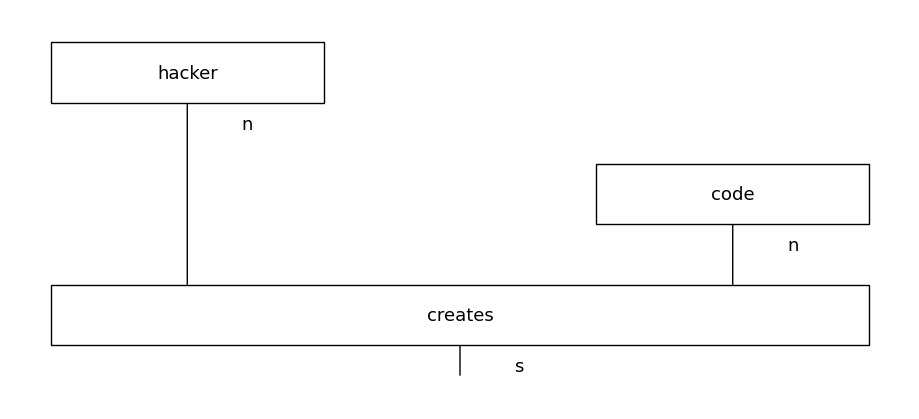

In [34]:
train_curried_diagram = []
curry_functor = Rewriter(['curry'])  

for diagram in n_train_diagrams:
     if diagram is not None:
        train_curried_diagram.append(curry_functor(diagram).normal_form())
      


train_curried_diagram[1].draw(figsize=(9,4), fontsize=13)

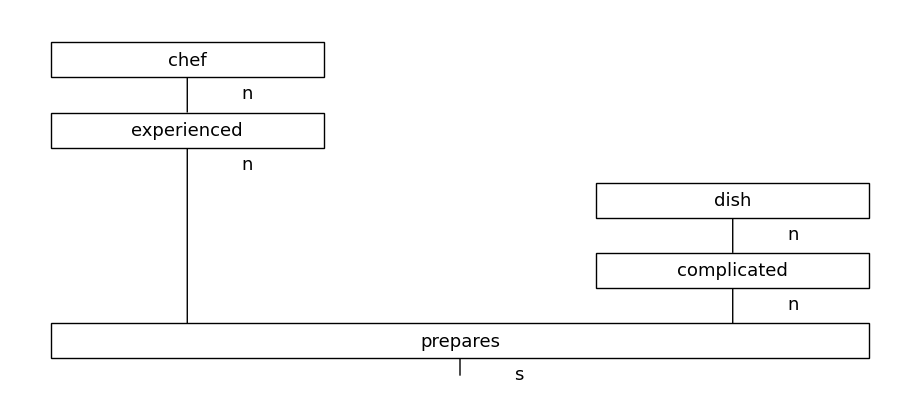

In [35]:
test_curried_diagram = []
curry_functor = Rewriter(['curry'])  

for diagram in n_test_diagrams:
     if diagram is not None:
        test_curried_diagram.append(curry_functor(diagram).normal_form())
      


test_curried_diagram[1].draw(figsize=(9,4), fontsize=13)

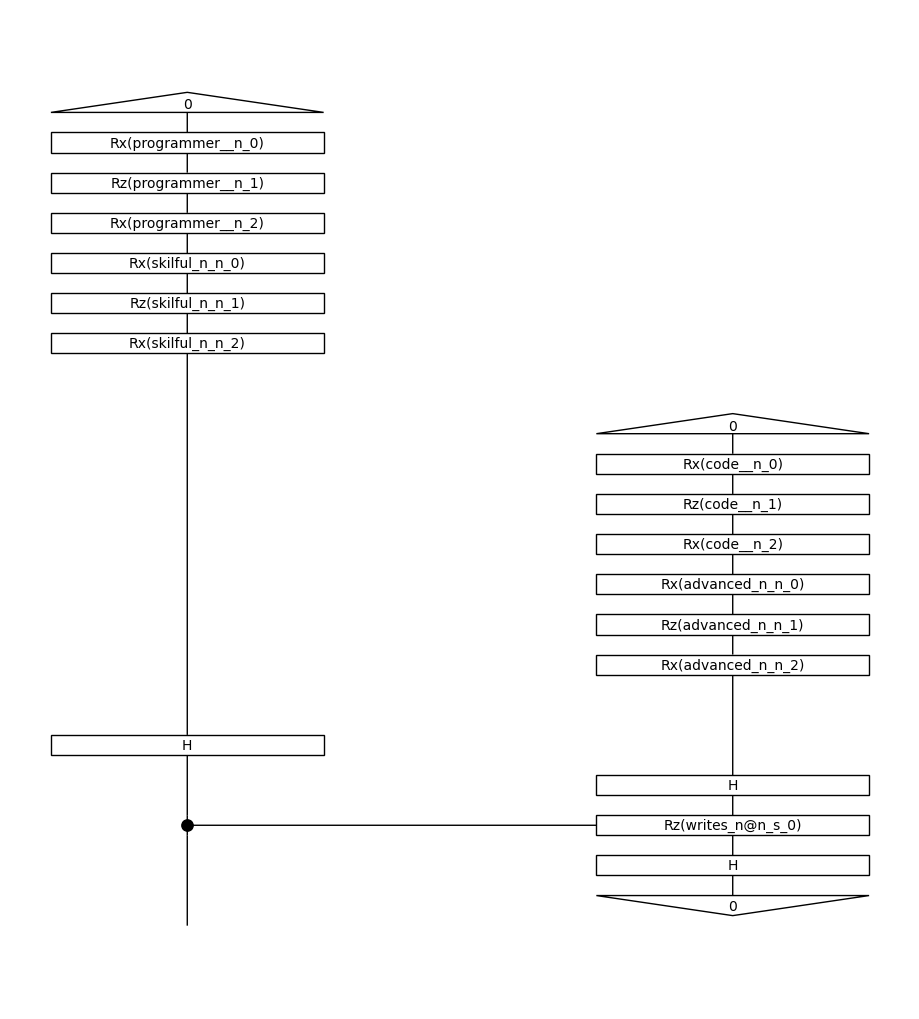

In [36]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram)  for diagram in train_curried_diagram if diagram is not None]
test_circuits =  [ansatz(diagram)  for diagram in test_curried_diagram if diagram is not None]
train_circuits[0].draw(figsize=(9, 10))

In [37]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [38]:
import numpy as np
##python numpy ValueError: operands could not be broadcast together with shapes

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [39]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels ,
            batch_size=BATCH_SIZE)

test_dataset = Dataset(test_circuits, test_labels , shuffle=False)

In [40]:
from lambeq import QuantumTrainer, SPSAOptimizer


trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.08, 'c': 0.09 , 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [41]:
trainer.fit(train_dataset, test_dataset, evaluation_step=1, logging_step=5)

Epoch 1:   train/loss: 1.4084   valid/loss: 2.5417   train/acc: 0.3059   valid/acc: 0.4000
Epoch 5:   train/loss: 0.9162   valid/loss: 0.7921   train/acc: 0.5647   valid/acc: 0.6000
Epoch 10:  train/loss: 0.5177   valid/loss: 0.2506   train/acc: 0.7529   valid/acc: 0.9333
Epoch 15:  train/loss: 0.3514   valid/loss: 0.1662   train/acc: 0.8353   valid/acc: 1.0000
Epoch 20:  train/loss: 0.2403   valid/loss: 0.2005   train/acc: 0.9059   valid/acc: 0.9333
Epoch 25:  train/loss: 0.2066   valid/loss: 0.1851   train/acc: 0.9176   valid/acc: 0.9333
Epoch 30:  train/loss: 0.1973   valid/loss: 0.2027   train/acc: 0.9176   valid/acc: 0.9333
Epoch 35:  train/loss: 0.1331   valid/loss: 0.1294   train/acc: 0.9647   valid/acc: 0.9333
Epoch 40:  train/loss: 0.1473   valid/loss: 0.1065   train/acc: 0.9412   valid/acc: 0.9333

Training completed!


Validation accuracy: 0.9333333333333333


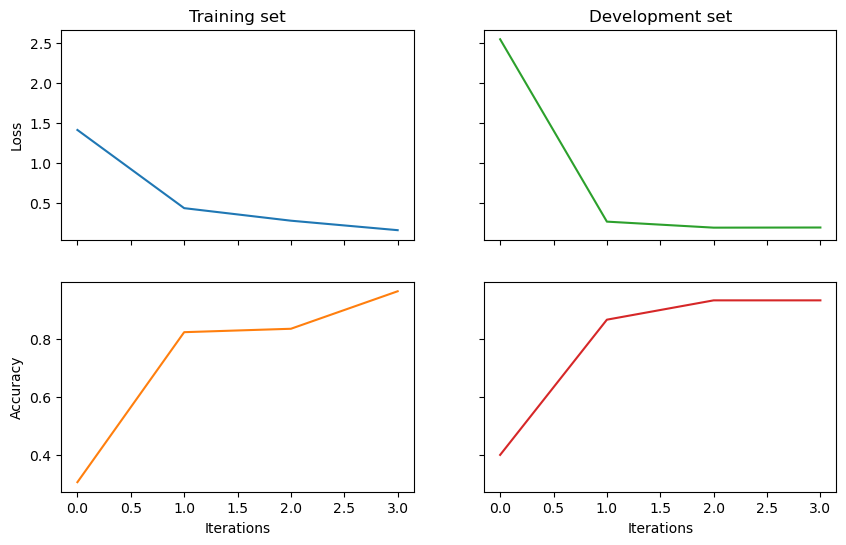

In [43]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

# print test accuracy
test_acc = acc(model(test_circuits), y_test)
print('Validation accuracy:', test_acc.item())

In [44]:
def result_label(prediction):
    food_score = prediction[0][0]
    IT_score = prediction[0][1]
    label = 0

    if food_score > IT_score:
        label = 1
        return label
    elif food_score <= IT_score:
        return label

In [45]:
def same_category(sentence1, sentence2):
    if result_label(sentence1) == result_label(sentence2) and result_label(sentence1) == 1:
        print("Both sentences are about food")
        group = "Same Category food"
        return group
    elif result_label(sentence1) == result_label(sentence2) and result_label(sentence1) == 0:
        print("Both sentences are about it")
        group = "Same Category IT"
        return group
    elif result_label(sentence1) == 1 and result_label(sentence2) == 0:
        print("Sentence 1 is about food and Sentence 2 is about IT")
        group = "Different Category"
        return group
    elif result_label(sentence1) == 0 and result_label(sentence2) == 1:
        print("Sentence 1 is about IT and Sentence 2 is about food")
        group = "Different Category"
        return group

In [46]:
def sentenceToCircit(sentence,rewriter,curry_functor,ansatz):


    # Parse the sentence and convert it into a string diagram
    parser = BobcatParser(verbose='suppress')
    diagram = parser.sentence2diagram(sentence)


    if diagram is not None:
        r_diagram = rewriter(diagram)
        n_diagram = r_diagram.normal_form()
        curried_diagram = curry_functor(n_diagram).normal_form()
        circuit = ansatz(curried_diagram)
        return circuit
    else:
        return None

In [52]:
sentenceCircuit1 = sentenceToCircit("hacker writes code .",rewriter,curry_functor,ansatz)
sentenceCircuit2 = sentenceToCircit("experienced chef prepares meal .",rewriter,curry_functor,ansatz)

In [69]:
# predicting on new input
prediction = model.forward([sentenceCircuit1])
prediction2 = model.forward([sentenceCircuit2])
result = prediction.tolist()
result2 = prediction2.tolist()
print(result)
print(result2)
same_category(result, result2)

[[0.9974587026444786, 0.0025412973555215034]]
[[0.8180212002627077, 0.18197879973729225]]
Both sentences are about food


'Same Category food'